#**Capstone project: Can ML Outperform Market-Neutral Trading in Structural Breaks?**

**Note:**

It's a good practise to "restart the session", whenever changes are made to the github repository


##**Step 1:** GitHub setup

1) Clone/Update the projects github repository

In [1]:
# Use for the first time to clone the github repo or when the repo is updated
%rm -rf /content/MarketNeutral_Trading/
%cd /content
!git clone https://github.com/WQU-Capstone-11205/MarketNeutral_Trading.git
%cd /content/MarketNeutral_Trading

/content
Cloning into 'MarketNeutral_Trading'...
remote: Enumerating objects: 1001, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1001 (delta 28), reused 5 (delta 5), pack-reused 953 (from 3)
Receiving objects: 100% (1001/1001), 2.19 MiB | 11.86 MiB/s, done.
Resolving deltas: 100% (559/559), done.
/content/MarketNeutral_Trading


2) Add the project's github repository's path to the system path

In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/content/MarketNeutral_Trading')

3) Install projects required packages

In [3]:
!pip install -r requirements.txt

##**Step 2:** Data loading

Load data and convert to distance spread

In [4]:
from data_loading.fetch_data import fetch_from_yfinance
from data_loading.distance_spread import distance_spread
from util.split_time_series import split_time_series
from util.ff_benchmark import get_ff_benchmark_returns

# Example pair: XLF and FAS (Financial sector ETFs, often cointegrated)
ticker1 = 'XLF'
ticker2 = 'FAS'# Note: FAS is a leveraged ETF, may require careful handling/interpretation
start_date = '2005-01-01'
end_date = '2025-01-01'
# Use an in-sample period for training the cointegration relationship
in_sample_cutoff_date = '2017-01-01' # After this date the cointegration fails

# Fetch a benchmark for alpha/beta calculation (e.g., SPY)
benchmark_data = fetch_from_yfinance(['SPY'], start_date, end_date)
benchmark_returns = benchmark_data.pct_change().dropna()
train_spy_returns = benchmark_returns.loc[:in_sample_cutoff_date]
test_spy_returns = benchmark_returns.loc[in_sample_cutoff_date:]
ff_benchmark_returns = get_ff_benchmark_returns(in_sample_cutoff_date, end_date)

spread = distance_spread([ticker1, ticker2], start_date=start_date, end_date=end_date)
train_spread = spread.loc[:in_sample_cutoff_date]
test_spread = spread.loc[in_sample_cutoff_date:]
spread_returns = spread.pct_change().dropna()
train_spread_returns = spread_returns.loc[:in_sample_cutoff_date]
test_spread_returns = spread_returns.loc[in_sample_cutoff_date:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


##**Step 3:** Hyperparameter tuning of BOCPD+VAE+TRAFO pipeline

Tune hyper-parameter for BOCPD+VAE+TRAFO pipeline.

In [5]:
bocpd_space = {
    "hazard": [15],
    "mu": [0],
    "kappa": [0.3],
    "alpha": [1.0],
    "beta": [0.6]
}

vae_space = {
    "input_dim": [2],
    "latent_dim": [12],
    "hidden_dim": [256],
    "lr": [0.001],
    "vae_seq_len": [1],
    "kl_wt": [0.001]
}

trafo_space = {
    "z_dim": [12],
    "d_model": [32],
    "nhead": [4],
    "num_layers": [2],
    "hidden_dim": [4], #"2*d_model", "3*d_model", "4*d_model"
    "lr": [0.001],
    "trafo_l2": [1e-3],
    "gamma": [0.99]
}

joint_space = {
    "state_window": [50],
    "base_action_sigma": [0.03],
    "wt_multplier": [1.5],
    "buffer_size_updates": [256],
    "sample_batch_size": [32],
    "transaction_cost": [0.001],
    "exploration_alpha": [6.5]
}

from tuning.bocpd_vae_trafo_tuner import BOCPD_VAE_TRAFO_Tuner

bocpd_vae_trafo_tuner = BOCPD_VAE_TRAFO_Tuner(bocpd_space, vae_space, trafo_space, joint_space)
#bocpd_vae_trafo_tuner = BOCPD_VAE_TRAFO_Tuner() # Full tune (takes more than 18 hours)

bocpd_vae_trafo_tuner.tune(train_spread)
bocpd_params, vae_params, trafo_params, joint_params = bocpd_vae_trafo_tuner.best_params

print(f'bocpd_params = {bocpd_params}')
print(f'vae_params = {vae_params}')
print(f'trafo_params = {trafo_params}')
print(f'joint_params = {joint_params}')
# It takes 8 hours for full tuning

bocpd score = -7 :: params = {'hazard': 15, 'mu': 0, 'kappa': 0.3, 'alpha': 1.0, 'beta': 0.6}
Best BOCPD parameters: {'hazard': 15, 'mu': 0, 'kappa': 0.3, 'alpha': 1.0, 'beta': 0.6}
Best BOCPD score: -7
vae score = -68.4263 :: params = {'input_dim': 2, 'latent_dim': 12, 'hidden_dim': 256, 'lr': 0.001, 'vae_seq_len': 1, 'kl_wt': 0.001}
Best vae parameters: {'input_dim': 2, 'latent_dim': 12, 'hidden_dim': 256, 'lr': 0.001, 'vae_seq_len': 1, 'kl_wt': 0.001}
Best vae score: -68.4263
Transformer score = -0.6383 :: params = {'z_dim': 12, 'd_model': 32, 'nhead': 4, 'num_layers': 2, 'hidden_dim': 4, 'lr': 0.001, 'gamma': 0.99, 'trafo_l2': 0.001}
Best Transformer parameters: {'z_dim': 12, 'd_model': 32, 'nhead': 4, 'num_layers': 2, 'hidden_dim': 4, 'lr': 0.001, 'gamma': 0.99, 'trafo_l2': 0.001}
Best Transformer score: -0.6383
Joint Tuning score = -0.4221 :: params = {'state_window': 50, 'base_action_sigma': 0.03, 'wt_multplier': 1.5, 'buffer_size_updates': 256, 'sample_batch_size': 32, 'transac

First we tuned with the BOCPD_VAE_TRAFO_Tuner.tune(). It was found that sharpe ratio of evalution loop was not upto the mark and also had an higher drawdown. So, we manually adjusted the hidden dimensions of TRAFO till the results were better.

The best parameters are as stated above. These can directly be used without tuning the model again. The model's complete automatic tuning takes roughly around 20 hours.

##**Step 4:** Training of BOCPD+VAE+TRAFO pipeline

This task takes around 70 minutes.

In [6]:
from train.train_loop_transformer import train_loop_trafo

train_loop_trafo(train_spread, bocpd_params, vae_params, trafo_params, joint_params, num_epochs=25)

100%|██████████| 2042/2042 [00:36<00:00, 55.92it/s]


Epoch 000 | recon=0.0335 | kl=0.0322 | policy=-0.0732
Train Epoch Sharpe=-0.090
Saved all models + optimizers
Saved best models at epoch 000 (Train Sharpe=-0.090)


100%|██████████| 2042/2042 [00:37<00:00, 54.70it/s]


Stop-loss triggered for 17 PnLs
Epoch 001 | recon=0.0092 | kl=0.2047 | policy=-0.0021
Train Epoch Sharpe=0.077
Saved all models + optimizers
Saved best models at epoch 001 (Train Sharpe=0.077)


100%|██████████| 2042/2042 [00:39<00:00, 51.89it/s]


Stop-loss triggered for 56 PnLs
Epoch 002 | recon=0.0008 | kl=0.2269 | policy=-0.0012
Train Epoch Sharpe=0.017
No improvement. Early stopping patience counter = 1/5


100%|██████████| 2042/2042 [00:39<00:00, 51.72it/s]


Stop-loss triggered for 1 PnLs
Epoch 003 | recon=0.0004 | kl=0.1850 | policy=-0.0036
Train Epoch Sharpe=0.382
Saved all models + optimizers
Saved best models at epoch 003 (Train Sharpe=0.382)


100%|██████████| 2042/2042 [00:42<00:00, 48.21it/s]


Stop-loss triggered for 1 PnLs
Epoch 004 | recon=0.0006 | kl=0.1509 | policy=-0.0033
Train Epoch Sharpe=0.068
No improvement. Early stopping patience counter = 1/5


100%|██████████| 2042/2042 [00:40<00:00, 50.16it/s]


Stop-loss triggered for 100 PnLs
Epoch 005 | recon=0.0006 | kl=0.1303 | policy=0.0046
Train Epoch Sharpe=-0.686
No improvement. Early stopping patience counter = 2/5


100%|██████████| 2042/2042 [00:44<00:00, 45.45it/s]


Stop-loss triggered for 2 PnLs
Epoch 006 | recon=0.0007 | kl=0.1204 | policy=0.0022
Train Epoch Sharpe=-0.057
No improvement. Early stopping patience counter = 3/5


100%|██████████| 2042/2042 [00:45<00:00, 44.55it/s]


Stop-loss triggered for 4 PnLs
Epoch 007 | recon=0.0008 | kl=0.1084 | policy=-0.0014
Train Epoch Sharpe=0.236
No improvement. Early stopping patience counter = 4/5


100%|██████████| 2042/2042 [00:44<00:00, 45.55it/s]

Stop-loss triggered for 103 PnLs
Epoch 008 | recon=0.0007 | kl=0.1001 | policy=0.0024
Train Epoch Sharpe=-0.431
No improvement. Early stopping patience counter = 5/5
EARLY STOPPING TRIGGERED at epoch 8
Training stopped early due to no improvement in Sharpe.
Transformer policy training complete.


##**Step 5:** Testing of BOCPD+VAE+Transformer pipeline:

In [7]:
from backtest.evaluate_loop_trafo import evaluate_loop_trafo

test_metrics = evaluate_loop_trafo(test_spread, bocpd_params, vae_params, trafo_params, joint_params)

Loaded models/opts


100%|██████████| 2011/2011 [00:07<00:00, 266.96it/s]


RMSE channel0 (spread, denorm): 1.016852
RMSE channel1 (cp prob):        0.057426

Evaluation complete.


##**Step 6:** Test metrics BOCPD+VAE+Transformer pipeline:

In [8]:
import numpy as np
from metrics.stats import sharpe_ratio, compute_max_drawdown, sortino_ratio, annual_volatility, alpha_beta

print("Test metrics for BOCPD+VAE+Transformer model:")
cum_pnl = np.cumsum(test_metrics['portfolio_returns'])
print(f"Cummulative profit and loss                       : {cum_pnl[-1]:.6f}")
print(f"Sharpe Ratio                                      : {sharpe_ratio(test_metrics['portfolio_returns']):.6f}")
print(f"Sortino ratio                                     : {sortino_ratio(test_metrics['portfolio_returns']):.6f}")
print(f"Max drawdown                                      : {compute_max_drawdown(np.cumsum(test_metrics['portfolio_returns'])):.6f}")
print(f"Annual Volatility                                 : {annual_volatility(test_metrics['portfolio_returns']):.6f}")
alpha_ff, beta_ff = alpha_beta(test_metrics['portfolio_returns'], ff_benchmark_returns)
print(f"Factor-adjusted Alpha-Beta                        : alpha = {alpha_ff:.6f} , beta = {beta_ff:.6f}")
alpha_spy, beta_spy = alpha_beta(test_metrics['portfolio_returns'], test_spy_returns)
print(f"CAPM Alpha-Beta versus SPY                        : alpha = {alpha_spy:.6f} , beta = {beta_spy:.6f}")

Test metrics for BOCPD+VAE+Transformer model:
Cummulative profit and loss                       : 23.719356
Sharpe Ratio                                      : 0.470451
Sortino ratio                                     : 1.139053
Max drawdown                                      : 0.372498
Annual Volatility                                 : 6.317961
Factor-adjusted Alpha-Beta                        : alpha = 3.049866 , beta = -0.579644
CAPM Alpha-Beta versus SPY                        : alpha = 3.079581 , beta = -0.693008


**Results Summary**

1. Profitability: This shows the strategy is profitable across the test period. The model makes money and does so without collapsing under complexity or overfitting.
2. Risk-Adjusted Performance: Moderate risk-adjusted performance, which is inline for a strategy tuned to react to structural breaks. The model also penalizes downside returns and avoids large negative swings.
3. Drawdown: The model stays aggressively adaptive in changing regimes instead of flattening or becoming inactive.
4. Volatility: It is mostly productive volatility rather than drawdown-heavy volatility.
5. Factor-Adjusted Alpha-Beta: This strategy generates returns unexplained by classical factors and also profit during market downturns.
6. CAPM Alpha-Beta (vs SPY): The model is not correlated with SPY, which is good for diversification.


##**Step 7:** Plots for BOCPD+VAE+Transformer pipeline
##7.1) **Original vs Reconstructed Spread (VAE):**

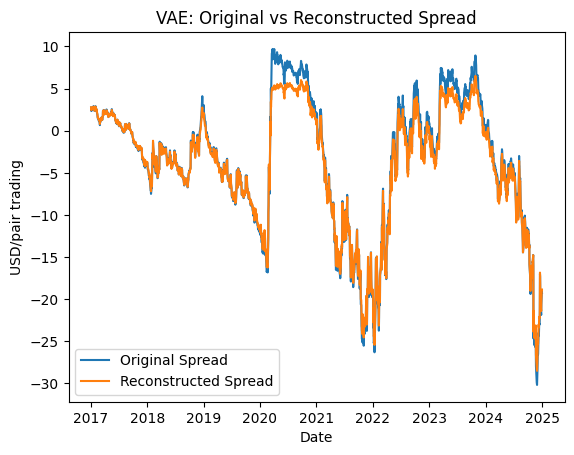

In [9]:
from plots.bocpd import vae_plot

vae_plot(test_spread, test_metrics['recons'])

## 7.2) **Drawdown for portfolio returns:**

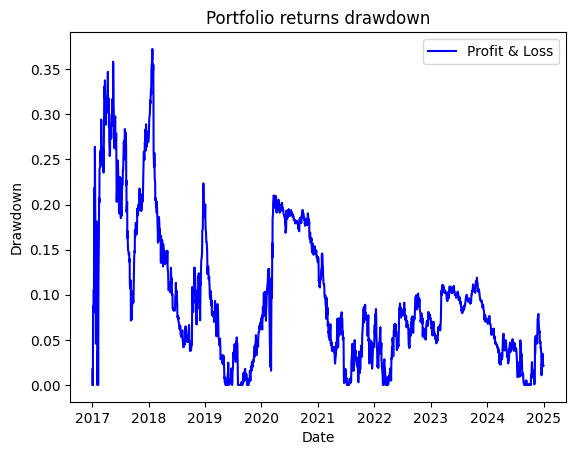

In [10]:
from plots.bocpd import drawdown_plot

drawdown_plot(test_metrics['rets'])

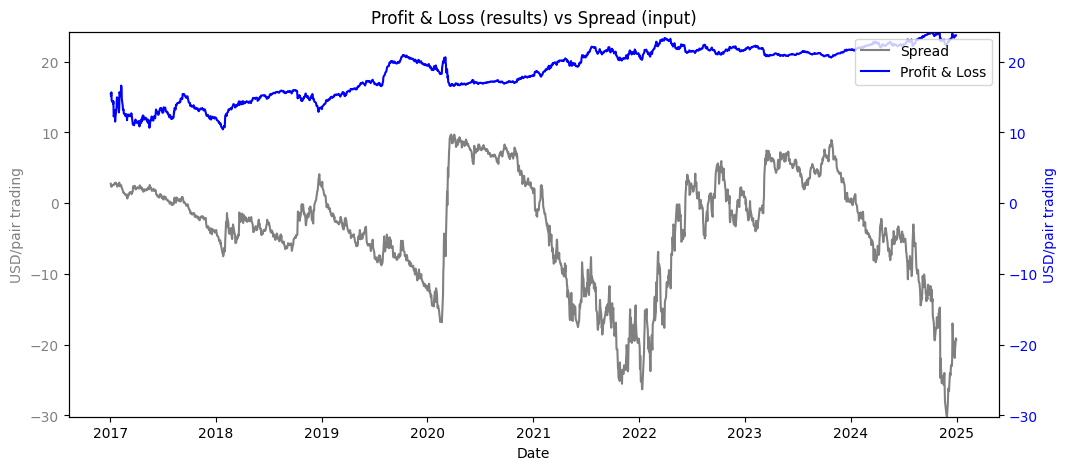

In [11]:
from plots.bocpd import compare_trends_plot

cumpnl = np.cumsum(test_metrics['portfolio_returns'])
compare_trends_plot(test_spread, cumpnl)

**From the plot:**

- The gray line represents the spread (left y-axis), and the blue line represents the cumulative PnL (profit and loss) of the BOCPD+VAE+Tx model (right y-axis).

- The PnL (blue) rises steadily during periods where the spread trends or exhibits strong mean-reverting behavior (e.g., 2017–2019 and again from 2022–2025), showing that the model is capturing profitable regimes.

- Around 2020, there’s a sharp PnL drop corresponding to a regime shift or structural break in the spread — likely a detected high-change-probability zone where the model temporarily misadapted.

- After 2021, the PnL stabilizes and then grows again, meaning the BOCPD+VAE combination successfully re-adapted to the new regime.

- The model’s PnL curve being mostly upward with some flat or drawdown zones indicates that the hybrid model adjusts to regime changes and continues to accumulate profits overall, though with occasional sharp losses during transition periods.

**Summary:**
The plot shows that your BOCPD+VAE+Tx system learns to exploit stable regimes profitably, experiences drawdowns during regime shifts, but overall maintains a positive, adaptive trading performance over time.

## 7.3) **Change Probability over time plot for BOCPD+VAE+Transformer pipeline:**

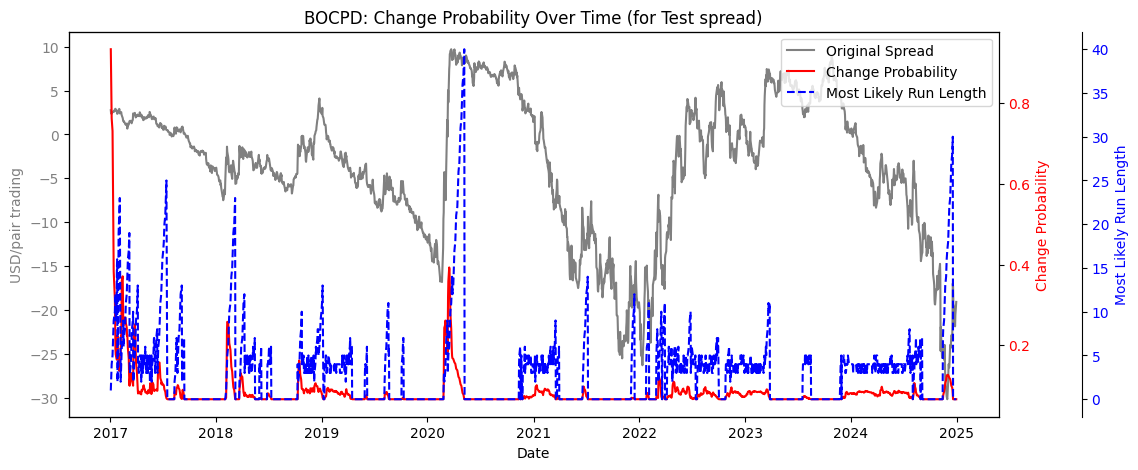

In [12]:
from plots.bocpd import plot_rt_change_probs

plot_rt_change_probs(test_spread, test_metrics['rt_mle'], test_metrics['change_probs'])

##**Step 8:** Metrics (Out-Of-Sample data)
##8.1) **Policy stability metrics:**

In [13]:
from metrics.policy_stability import policy_stability_metrics

perf_metric = policy_stability_metrics(test_metrics['actions'], eps=1e-3)
print("Policy stability metrics:")
print(f"Reversal rate per step    : {round(perf_metric['reversal_rate_per_step'],4)}")
print(f"Autocorrelation at lag-1  : {round(perf_metric['acf1'],4)}")


Policy stability metrics:
Reversal rate per step    : 0.0428
Autocorrelation at lag-1  : 0.9634


##8.2) **Adaptation Lag metrics:**

In [14]:
from plots.adaptation_lags import plot_stabilization_lag_distributions, plot_variance_vs_lag
from metrics.policy_stability import compute_adaptation_lags, generate_stabilization_lag_report

change_indices = np.where(test_metrics['cp_flags'] == 1)[0]
details = compute_adaptation_lags(test_spread.index, test_metrics['portfolio_returns'], test_metrics['change_probs'], test_metrics['cp_flags'])
df, summary = generate_stabilization_lag_report(details)
print("Stabilization metrics (portfolio returns):")
print(f'mean_stabilization_lag : {round(summary['mean_stabilization_lag'],4)}')
print(f'p95_stabilization_lag : {round(summary['p95_stabilization_lag'],4)}')



Stabilization metrics (portfolio returns):
mean_stabilization_lag : 15.3333
p95_stabilization_lag : 27.6


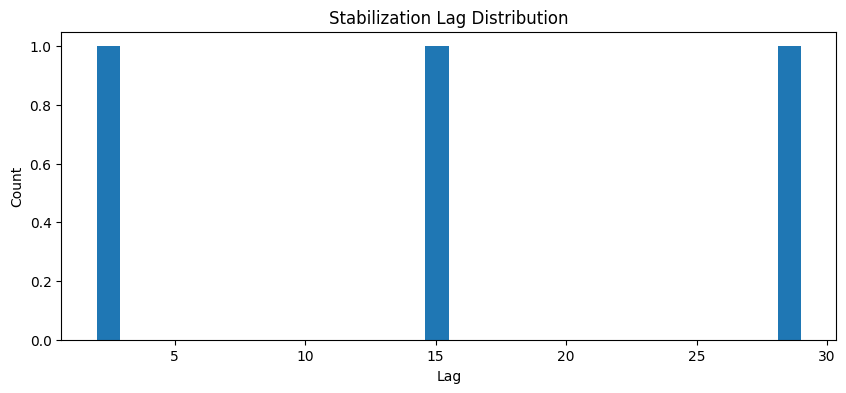

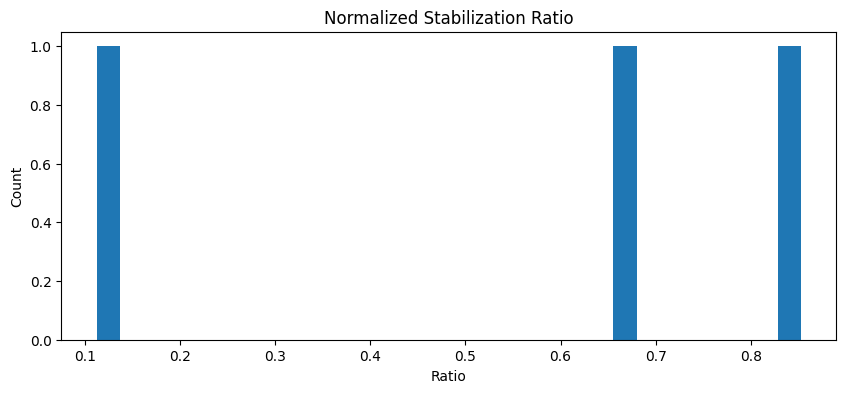

In [15]:
plot_stabilization_lag_distributions(df)


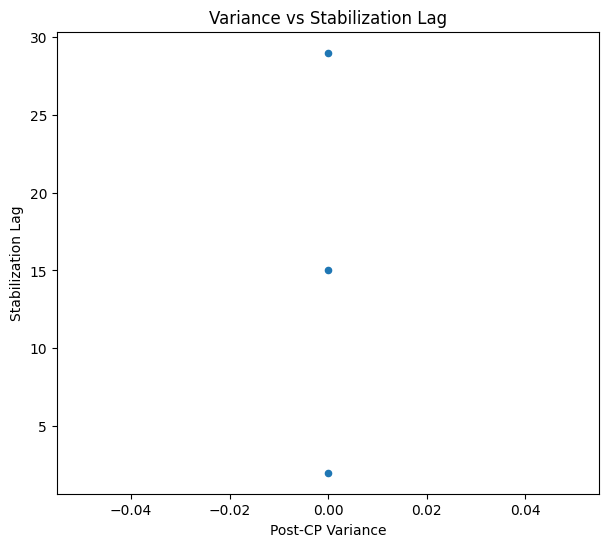

In [16]:
plot_variance_vs_lag(df)